# The FWL Theorem, Or How To Make All Regressions Intuitive

*An introduction to the Frisch-Waugh-Lowell theorem and how to use it to gain intuition in linear regressions*

The Frisch-Waugh-Lowell theorem is a **simple** but yet **powerful** theorem that allows us to reduce multivariate regressions to **univariate** ones. This is extremely useful when we are interested in the relationship between two variables, but we still need to control for other factors, as it is often the case in **causal inference**.

In this blog post, I am going to introduce the Frisch-Waugh-Lowell theorem and illustrate some interesting applications.

## The Theorem

The theorem was first published by [Ragnar Frisch and Frederick Waugh in 1933](https://www.jstor.org/stable/1907330). However, since its proof was lengthy and cumbersome, [Michael Lovell in 1963](https://www.tandfonline.com/doi/abs/10.1080/01621459.1963.10480682) provided a very simple and intuitive proof and his name was added to the theorem name.

The theorem states that, when estimating a model of the form

$$
y_i = \beta_1 x_{i,1} + \beta_2 x_{i,2} + \varepsilon_i
$$

then, the following estimators of $\beta_1$ are equivalent:

- the OLS estimator obtained by regressing $y$ on $x_1$ and $x_2$
- the OLS estimator obtained by regressing $y$ on $\tilde x_1$
    - where $\tilde x_1$ is the residual from the regression of $x_1$ on $x_2$
- the OLS estimator obtained by regressing $\tilde y$ on $\tilde x_1$
    - where $\tilde y$ is the residual from the regression of $y$ on $x_2$

### Interpretation

What did we actually **learn**?

The **Frisch-Waugh-Lowell theorem** is telling us that there are multiple ways to estimate a single regression coefficient. One possibility is to run the full regression of $y$ on $x$, as usual. 

However, we can also regress $x_1$ on $x_2$, take the residuals, and regress $y$ only those residuals. The first part of this process is sometimes referred to as **partialling-out** (or *orthogonalization*, or *residualization*) of $x_1$ with respect to $x_2$. The idea is that we are isolating the variation in $x_1$ that is *orthogonal* to $x_2$. Note that $x_2$ can be also be multi-dimensional (i.e. include multiple variables and not just one).

Why would one ever do that?

This seems like a way more **complicated** procedure. Instead of simply doing the regression in 1 step, now we need to do 2 or even 3 steps. It's not intuitive at all. The main advantage comes from the fact that we have reduced a multivariate regression to a univariate one, making more tractable and more intuitive.

We will later explore more in detail three **applications**:

- data visualization
- computational speed
- further applications for inference

However, let's first explore the theorem more in detail with an example.

## Example

Suppose we were a retail chain, owning many different stores in different locations. We come up with a brilliant **idea to increase sales**: give away discounts in the form of **coupons**. We print a lot of coupons and we distribute them around. 

To understand whether our marketing strategy worked, in each store, we check the average daily `sales` and which percentage of shoppers used a `coupon`. However, there is one **problem**: we are worried that higher income people are less likely to use the discount, but usually they spend more. To be safe, we also record the average `income` in the neighborhood of each store. 

We can represent the data generating process with a **Directed Acyclic Graph** (DAG). If you are not familiar with DAGs, I have written a short introduction to [Directed Acyclic Graphs here](https://medium.com/towards-data-science/controls-b63dc69e3d8c).

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((coupons))
X2((income))
X3((weekday))
Y((sales))


X1 --> Y
X2 --> X1
X2 --> Y
X3 --> Y

class X1,X2,X3,Y excluded;
```

Let's load and inspect the **data**. I import the data generating process from `src.dgp` and some plotting functions and libraries from `src.utils`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_store_coupons

df = dgp_store_coupons().generate_data(N=50)
df.head()

,sales,coupons,income,dayofweek
0,821.7,0.199,66.243,2
1,602.3,0.245,43.882,3
2,655.1,0.162,44.718,5
3,625.8,0.269,39.270,4
4,696.6,0.186,58.654,1


We have information on **50 stores**, for which we observe the percentage of customers that use `coupons`, daily `sales` (in thousand \$), average `income` of the neighborhood (in thousand \$), and `day of the week`.

Suppose we were directly regressing `sales` on `coupon` usage. What would we get? I represent the **result** of the regression graphically, using `seaborn` `regplot`.

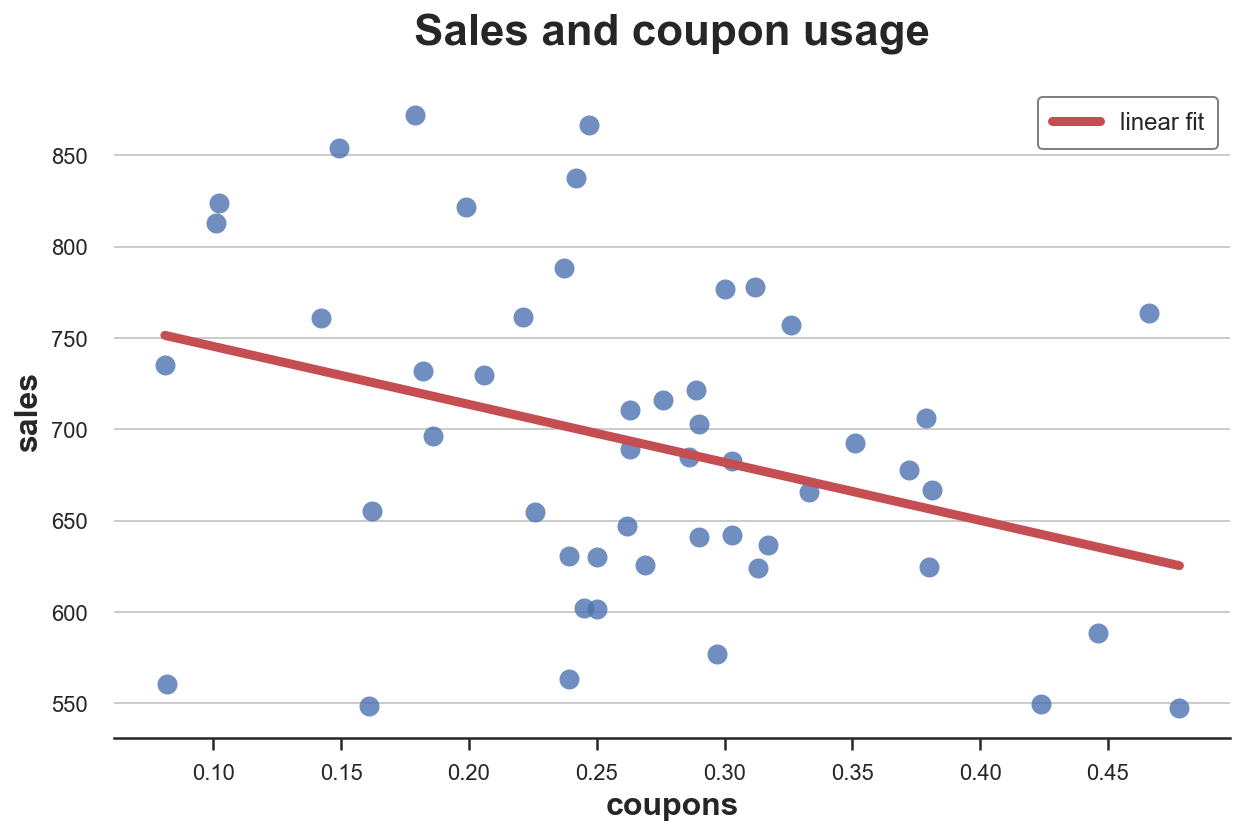

In [3]:
sns.regplot(x="coupons", y="sales", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Sales and coupon usage");

It looks like coupons were a **bad idea**: in stores where coupons are used more, we observe lower sales. 

However, it might just be that people with higher income are using less coupons, while also spending more. If this was true, it could **bias** our results. In terms of the DAG, it means that we have a **backdoor path** passing through `income`, generating a non-causal relationship.

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((coupons))
X2((income))
X3((weekday))
Y((sales))


X1 --> Y
X2 --> X1
X2 --> Y
X3 --> Y

class X1,Y included;
class X2,X3 excluded;

linkStyle 1,2 stroke:#ff0000,stroke-width:4px;
```

In order to recover the causal effect of `coupons` on `sales` we need to **condition** our analysis on `income`. This will **block** the non-causal path passing through `income`, leaving only the direct path from `coupons` to `sales` open, allowing us to estimate the causal effect.

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;


X1((coupons))
X2((income))
X3((weekday))
Y((sales))


X1 --> Y
X2 -.-> X1
X2 -.-> Y
X3 --> Y

class X1,X2,Y included;
class X3 excluded;

linkStyle 0 stroke:#00ff00,stroke-width:4px;
```

Let's implement this, by including `income` in the regression.

In [4]:
smf.ols('sales ~ coupons + income', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,161.4982,33.253,4.857,0.000,94.601,228.395
coupons,218.7548,50.058,4.370,0.000,118.052,319.458
income,9.5094,0.480,19.818,0.000,8.544,10.475


Now the estimated effect of `coupons` on `sales` is positive and significant. Coupons were actually a **good idea** after all.

### Verifying the Theorem

Let's now verify that the Frisch-Waugh-Lowell theorem actually holds. In particular, we want to check whether we get the **same coefficient** if, instead of regressing `sales` on `coupons` and `income`, we were

- regressing `coupons` on `income`
- computing the residuals `coupons_tilde`, i.e. the variation in `coupons` **not** explained by `income`
- regressing `sales` on `coupons_tilde`

In [5]:
df['coupons_tilde'] = smf.ols('coupons ~ income', df).fit().resid

smf.ols('sales ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,218.7548,1275.236,0.172,0.865,-2343.929,2781.438


Yes, the coefficient is the same! However, the **standard errors** now have increased a lot and the estimated coefficient is not significantly different from zero anymore. 

A better approach is to add a further step and repeat the same procedure also for `sales`: 

- regressing `sales` on `income`
- computing the residuals `sales_tilde`, i.e. the variation in `sales` **not** explained by `income`

and finally regress `sales_tilde` on `coupons_tilde`.

In [6]:
df['sales_tilde'] = smf.ols('sales ~ income', df).fit().resid

smf.ols('sales_tilde ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,218.7548,49.025,4.462,0.000,120.235,317.275


The coefficient is still exactly the same, but now also the standard errors are almost identical.

### Projection

What is **partialling-out** (or residualization, or orthogonalization) actually doing? What is happening when we take the residuals of `coupons` with respect to `income`?

We can **visualize** the procedure in a plot. First, let's actually display the **residuals** of `coupons` with respect to income.

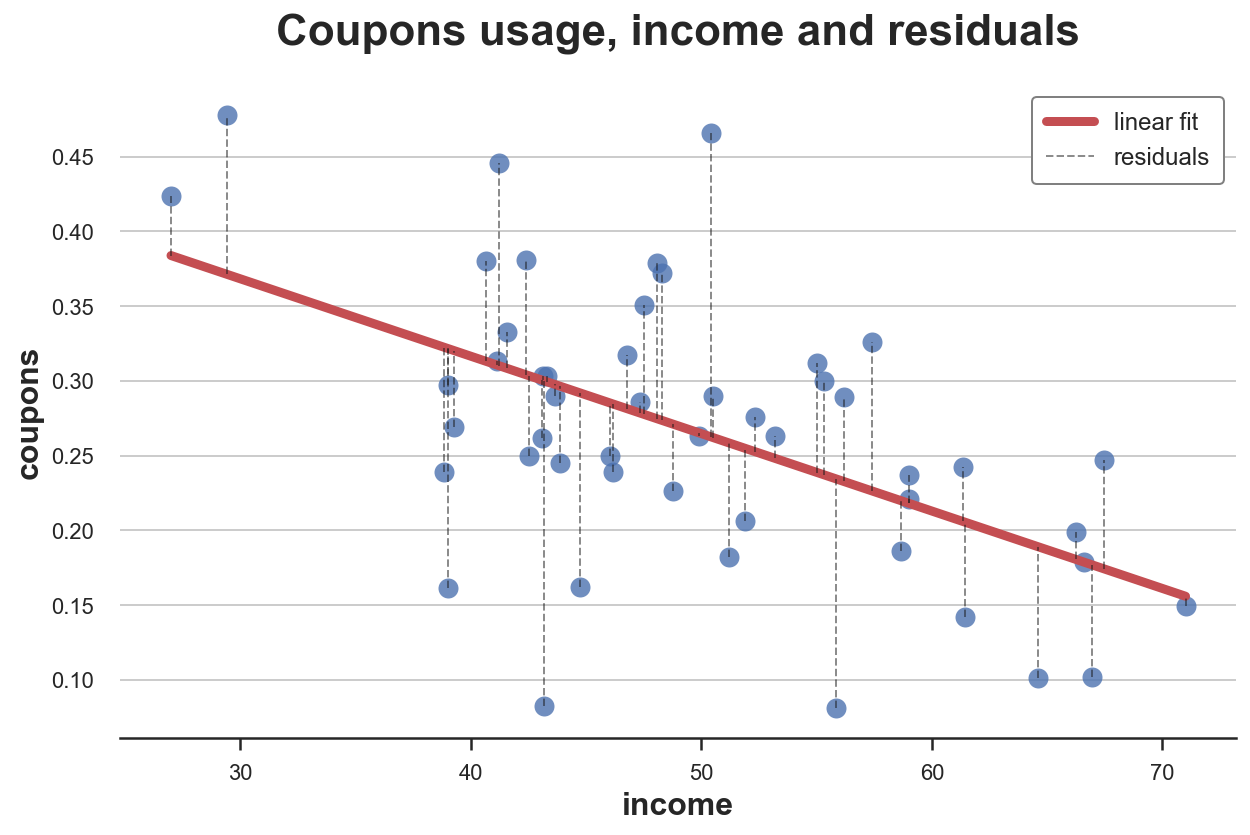

In [7]:
df["coupons_hat"] = smf.ols('coupons ~ income', df).fit().predict()
ax = sns.regplot(x="income", y="coupons", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
ax.vlines(df["income"], np.minimum(df["coupons"], df["coupons_hat"]), np.maximum(df["coupons"], df["coupons_hat"]), 
           linestyle='--', color='k', alpha=0.5, linewidth=1, label="residuals");
plt.legend()
plt.title(f"Coupons usage, income and residuals");

The **residuals** are the vertical dotted lines between the data and the linear fit, i.e. the part of the variation in `coupons` unexplained by `income`.

By **partialling-out**, we are removing the linear fit from the data and keeping only the residuals. We can visualize this procedure with a gif. I import the code from the `src.figures` file that you can find [here](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/figures.py).

In [8]:
from src.figures import gif_projection

gif_projection(x='income', y='coupons', df=df, gifname="gifs/fwl.gif")

![fwl](gifs/fwl.gif)

The original distribution of the data is on the left in *blue*, the partialled-out data in on the right in *green*. As we can see, partialling-out removes both the level and the trend in `coupons` that is explained by `income`.

### Multiple Controls

We can use the Frisch-Waugh-Theorem also when we have **multiple control variables**. Suppose that we wanted to also include `day of the week` in the regression, to increase precision.

In [9]:
smf.ols('sales ~ coupons + income + dayofweek', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,124.2721,28.764,4.320,0.000,66.182,182.362
dayofweek[T.2],7.7703,14.607,0.532,0.598,-21.729,37.270
dayofweek[T.3],15.0895,11.678,1.292,0.204,-8.495,38.674
dayofweek[T.4],28.2762,9.868,2.866,0.007,8.348,48.204
dayofweek[T.5],44.0937,10.214,4.317,0.000,23.467,64.720
dayofweek[T.6],50.7664,13.130,3.866,0.000,24.249,77.283
dayofweek[T.7],57.3142,12.413,4.617,0.000,32.245,82.383
coupons,192.0262,39.140,4.906,0.000,112.981,271.071
income,9.8152,0.404,24.314,0.000,9.000,10.630


We can perform the same procedure as before, but instead of **partialling-out** only `income`, now we partial out both `income` and `day of the week`.  

In [10]:
df['coupons_tilde'] = smf.ols('coupons ~ income + dayofweek', df).fit().resid
df['sales_tilde'] = smf.ols('sales ~ income + dayofweek', df).fit().resid
smf.ols('sales_tilde ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,192.0262,35.803,5.363,0.000,120.078,263.974


We still get exactly the same coefficient!

## Applications

Let's now inspect some useful applications of the FWL theorem.

### Data Visualization

One of the advantages of the Frisch-Waugh-Theorem is that it allows us to estimate the coefficient of interest from a **univariate** regression, i.e. with a single explanatory variable (or feature).

Therefore, we can now represent the relationship of interest **graphically**. Let's plot the residual `sales` against the residual `coupons`.

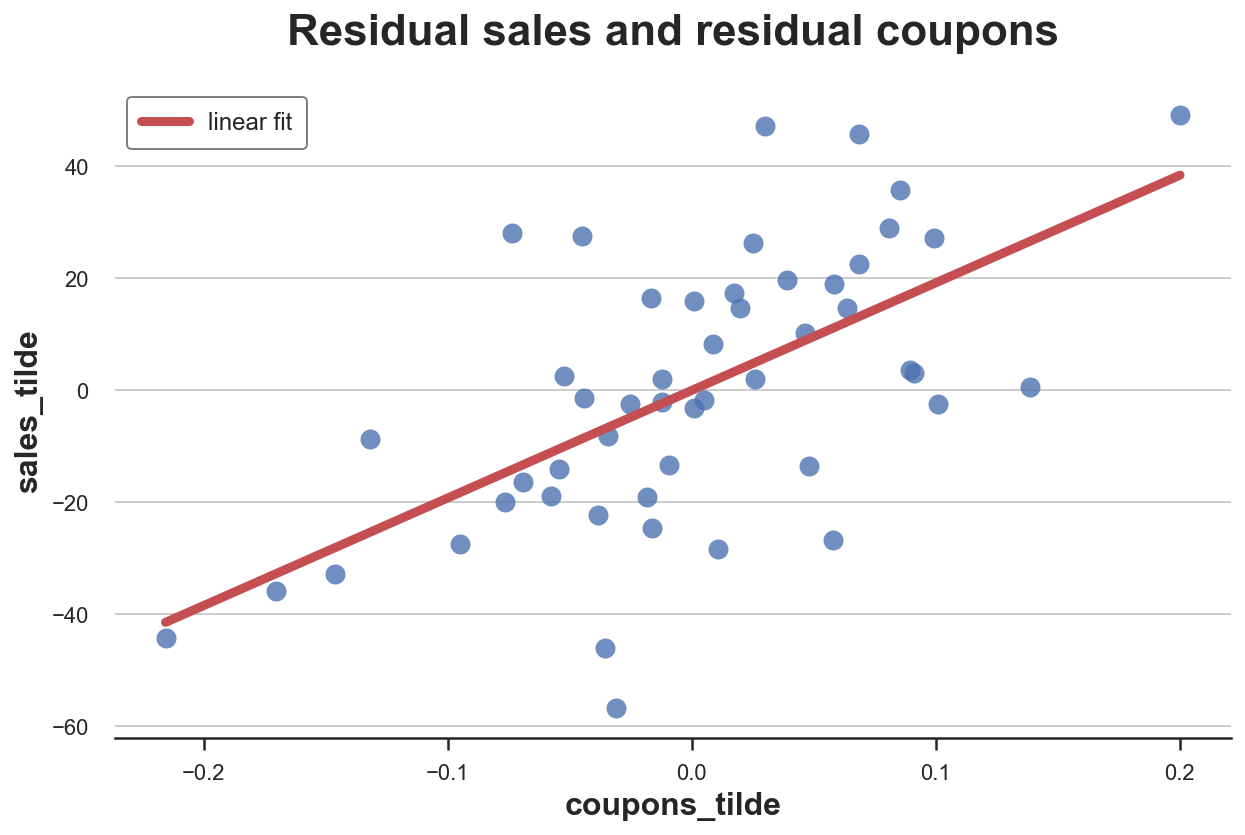

In [11]:
sns.regplot(x="coupons_tilde", y="sales_tilde", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Residual sales and residual coupons");

Now it's evident from the graph that the **conditional relationship** between `sales` and `coupons` is positive.

One problem with this approach is that the variables are **hard to interpret**: we now have negative values for both `sales` and `coupons`. Weird. 

Why did it happen? It happened because when we partialled-out the variables, we included the **intercept** in the regression, effectively de-meaning the variables (i.e. normalizing their values so that their mean is zero).

We can **solve** this problem by **scaling** both variables, adding their mean. 

In [12]:
df['coupons_tilde_scaled'] = df['coupons_tilde'] + np.mean(df['coupons'])
df['sales_tilde_scaled'] = df['sales_tilde'] + np.mean(df['sales'])

Now the magnitudes of the two variables are interpretable again. 

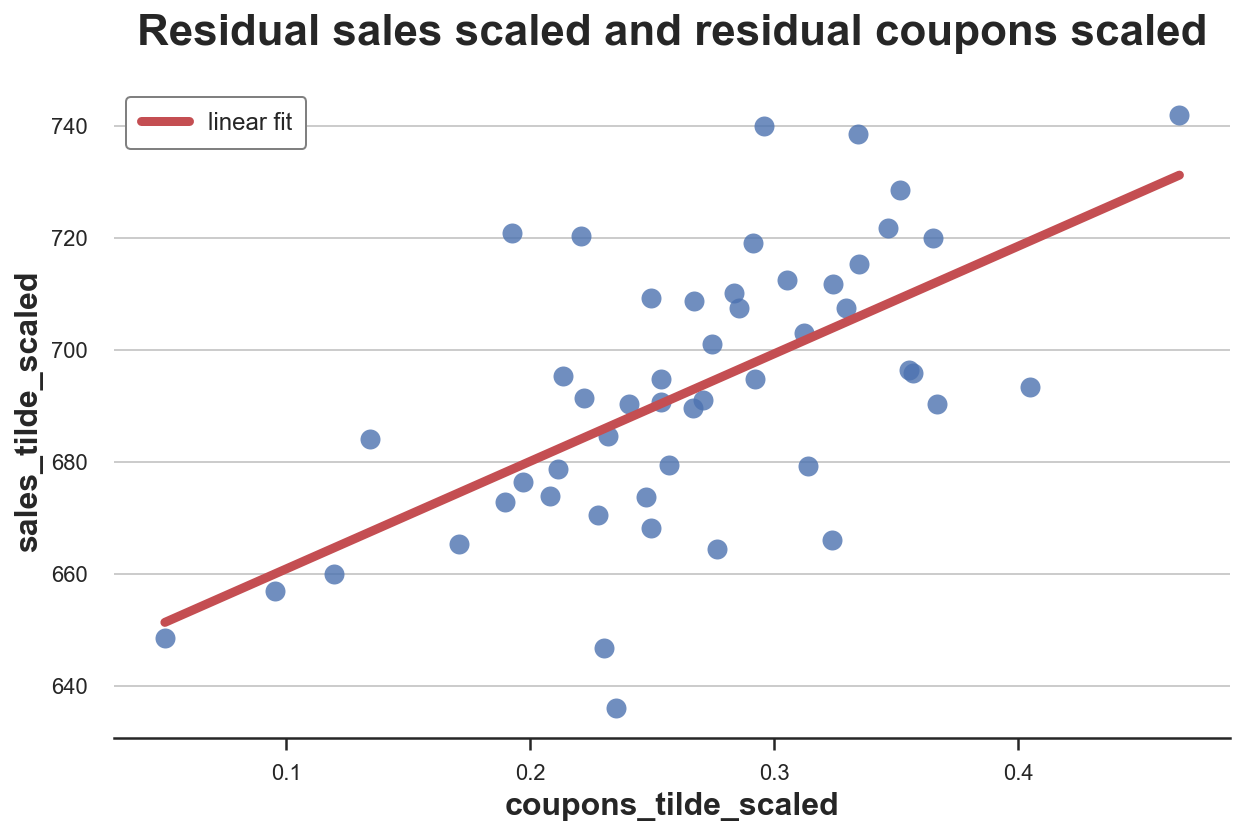

In [13]:
sns.regplot(x="coupons_tilde_scaled", y="sales_tilde_scaled", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Residual sales scaled and residual coupons scaled");

Is this a **valid** approach or did it alter our estimates? We can can check it by running the regression with the scaled partialled-out variables.

In [14]:
smf.ols('sales_tilde_scaled ~ coupons_tilde_scaled', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,641.6486,10.017,64.054,0.000,621.507,661.790
coupons_tilde_scaled,192.0262,36.174,5.308,0.000,119.294,264.758


The coefficient is exactly the same as before!

### Computational Speed

Another application of the Frisch-Waugh-Lovell theorem is to increase the computational speed of linear estimators. For example it is used to compute efficient linear estimators in presence of high-dimensional fixed effects (`day of the week` in our example).

Some packages that exploit the Frisch-Waugh-Lovell theorem include

- [reghdfe in Stata](http://scorreia.com/software/reghdfe/)
- [pyhdfe in Python](https://pyhdfe.readthedocs.io/en/stable/index.html)

However, it's important to also mention the [fixest](https://cran.r-project.org/web/packages/fixest/index.html) package in R, which is also exceptionally efficient in running regressions with high dimensional fixed effects.

### Inference and Machine Learning

Another important application of the FWL theorem sits at the intersection of **machine learning** and **causal inference**. I am referring to the work on post-double selection by [Belloni, Chernozhukov, Hansen (2013)](https://academic.oup.com/restud/article-abstract/81/2/608/1523757) and the follow up work on "double machine learning" by [Chernozhukov, Chetverikov, Demirer, Duflo, Hansen, Newey, Robins (2018)](https://academic.oup.com/ectj/article/21/1/C1/5056401).

I plan to cover both applications in future posts, but I wanted to start with the basics. Stay tuned!

## References

[1] R. Frisch and F. V. Waugh, [Partial Time Regressions as Compared with Individual Trends](https://www.jstor.org/stable/1907330) (1933), *Econometrica*.

[2] M. C. Lowell, [Seasonal Adjustment of Economic Time Series and Multiple Regression Analysis](https://www.tandfonline.com/doi/abs/10.1080/01621459.1963.10480682) (1963), *Journal of the American Statistical Association*.